# Could Model Wind Turbine Load Predictor

In this notebook it is possible to test and see the predicted results of a pretrained Wind Load Prediction model.

To do this you have to update the Inputs cell below with the correct information. Next you have to click Run All and the model will be imported and tested on the given Dataset. The testdata concists of 10 minute long simulations. The prediction vs true value graphs that are plotted below each contain 1/3 of the simulation so the differences (or similarities) between the predictions and true values are better visible.

## Inputs

In [1]:
# Specify which load axis the chosen model is trained on: Blade 1 Root bending moment in the x- or y-direction
load_x_or_y = 'y'

# Input file path to the pretrained model
model_path = "/kaggle/input/windturbine_bending_moment_predictors/pytorch/default/1/Could_My_v2.pth"

# Define the directories containing the two linked file sets
input_data = '/kaggle/input/could-dataset2/dataset2/Inputs'
output_data = '/kaggle/input/could-dataset2/dataset2/Outputs'

## Importing the needed modules

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
from collections.abc import Iterable
from datetime import date
import os
import random
import math

print("Loading modules completed.")

Loading modules completed.


## Defining the model

In [3]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, kernel_size, out_channels=1, stride=1):
        super(CNNFeatureExtractor, self).__init__()

        # Define the convolutional layer
        self.conv = nn.Conv2d(
            in_channels=1,  # Single-channel input
            out_channels=out_channels,  # Number of output channels
            kernel_size=(kernel_size, kernel_size),  # Kernel size
            stride=(stride, stride),  # Stride
            padding=0  # No padding
        )
        
        # Define a flattening layer
        self.flatten = nn.Flatten()  # Flattens the output to a 1D vector

    def forward(self, x):
        batch_size, seq_len, height, width = x.size()  # Input: [Batch size, sequence length, Height, Width]
        x = x.view(batch_size * seq_len, 1, height, width)  # Reshape to [B * seq_len, 1, Height, Width]
        x = self.conv(x)  # Apply convolution: [B * seq_len, out_channels, new_height, new_width]
        x = x.view(batch_size * seq_len, -1)  # Flatten to [B * seq_len, new_height * new_width]
        x = x.view(batch_size, seq_len, -1)  # Reshape back to [Batch size, sequence length, feature_dim]
        return x


class RNNModel(nn.Module):
    def __init__(self, feature_dim, hidden_dim, output_dim, num_layers, dropout_prob):
        super(RNNModel, self).__init__()
        self.lstm = nn.LSTM(feature_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)  # LSTM layer
        x = self.dropout(x)  # Apply dropout to the LSTM outputs
        x = self.fc(x)  # Fully connected layer for predictions
        return x



# Combine CNN and RNN into a single model
class WindTurbineLoadPredictor(nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, kernel_size, out_channels, stride, input_height, input_width, dropout_prob, angle_dim=1):
        super(WindTurbineLoadPredictor, self).__init__()
        self.cnn = CNNFeatureExtractor(kernel_size, out_channels, stride)

        # Dynamically calculate the CNN output feature dimension
        dummy_input = torch.zeros(1, 1, input_height, input_width)  # Example input: [Batch size, Channels, Height, Width]
        dummy_output = self.cnn.conv(dummy_input)  # Apply only the CNN convolution
        cnn_feature_dim = dummy_output.numel()  # Total elements in the CNN output per sample

        # Initialize the RNN with the calculated feature_dim + angle_dim
        self.rnn = RNNModel(cnn_feature_dim + angle_dim, hidden_dim, output_dim, num_layers, dropout_prob)

    def forward(self, x, x1):
        cnn_output = self.cnn(x)  # Extract spatial features
        seq_len = cnn_output.size(1)

        # Expand and concatenate x1 (scalar feature)
        x1 = x1.unsqueeze(-1).expand(-1, seq_len, -1)  # Shape: [Batch, seq_len, 1]
        combined_features = torch.cat((cnn_output, x1), dim=-1)  # Concatenate along the feature axis

        x = self.rnn(combined_features)  # Model temporal dependencies
        return x


print("Defining model completed.")

Defining model completed.


In [4]:
class WindTurbineDataset(Dataset):
    def __init__(self, input_files, target_files, scaling_factors, load_x_or_y, input_transform=None, target_transform=None):
        """
        Dataset class for Wind Turbine data with lazy loading.

        Parameters:
        -----------
        input_files: list of str, List of file paths for input data.
        target_files: list of str, List of file paths for target data.
        input_transform: callable, optional, A function or transformation to apply to the inputs.
        target_transform: callable, optional, A function or transformation to apply to the targets.
        """
        self.input_files = input_files
        self.target_files = target_files
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.scaling_factors = scaling_factors
        self.load_x_or_y = load_x_or_y

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        # Load the input and target data for the given index
        angle_data = self._load_angles(self.target_files[idx])
        target_data = self._load_targets(self.target_files[idx])
        self.target_length = target_data.shape[0]
        Turbsim_data = self._load_inputs(self.input_files[idx])
        time_data = self._load_time(self.target_files[idx])
        
        # Apply global normalization
        Turbsim_data = self._normalize(Turbsim_data, self.scaling_factors["Turbsim_min"], self.scaling_factors["Turbsim_max"], to_range=(0, 1))
        angle_data = self._normalize(angle_data, self.scaling_factors["angle_min"], self.scaling_factors["angle_max"], to_range=(0, 1))

        return Turbsim_data, angle_data, target_data, time_data


    def _load_inputs(self, file_path):
        # Input data from shape (1200, 14, 11) to (15000, 14, 11) to match the output lenght
        data = np.load(file_path)  
        target_length = self.target_length 
        current_length = data.shape[0]
    
        # Interpolation to the target length (15000 steps)
        time_steps_input = np.arange(current_length)  # 
        time_steps_target = np.linspace(0, current_length - 1, target_length)  
        interpolation_function = interpolate.interp1d(time_steps_input, data, kind='linear', axis=0)
        inputs_stretched = interpolation_function(time_steps_target)  # Result will have shape [15000, 41, 33]
        
        return torch.tensor(inputs_stretched).float()  
        

    def _load_targets(self, file_path):
        data = np.load(file_path)  
        if load_x_or_y == 'x' or load_x_or_y == 'X':
            data = data[:, 1]          # Keep only the RootMxb1 column
        elif load_x_or_y == 'y' or load_x_or_y == 'Y':
            data = data[:, 2]          # Keep only the RootMyb1 column
        return torch.tensor(data)
    
    def _load_angles(self, file_path):
        data = np.load(file_path)  
        data = data[:, 3]          # Keep only the Angles column
        return torch.tensor(data)  

    def _load_time(self, file_path):
        data = np.load(file_path)  
        data = data[:, 0]          # Keep only the Time column
        return torch.tensor(data)  

    @staticmethod
    def _normalize(data, min_val, max_val, to_range=(0, 1)):
        range_min, range_max = to_range
        normalized = (data - min_val) / (max_val - min_val + 1e-8)
        return normalized * (range_max - range_min) + range_min

    def shapes(self):
        sample_Turbsim, sample_angle, sample_target, sample_time = self[0]
        return sample_Turbsim.shape, sample_angle.shape, sample_target.shape, sample_time.shape

#Function for re-scaling
def _denormalize(normalized_data, min_val, max_val, from_range=(-1, 1)):
    range_min, range_max = from_range
    original = (normalized_data - range_min) / (range_max - range_min + 1e-8)
    return original * (max_val - min_val) + min_val

print("Defining Dataloader completed.")

Defining Dataloader completed.


In [5]:
def compute_global_scaling_factors(input_files, target_files):
    """
    Compute global min and max values for input and target data by iterating over all files.
    
    Parameters:
    -----------
    input_files: list of str, List of file paths for input data.
    target_files: list of str, List of file paths for target data.
    
    Returns:
    --------
    dict
        Dictionary containing global min and max values for inputs and targets.
    """
    # Initialiseer min en max waarden
    input_min = float('inf')
    input_max = float('-inf')
    angle_min = float('inf')
    angle_max = float('-inf')

    if load_x_or_y == 'x' or load_x_or_y == 'X':
        target_column = 1         # Keep only the RootMxb1 column
    elif load_x_or_y == 'y' or load_x_or_y == 'Y':
        target_column = 2         # Keep only the RootMxb1 column
    
    # Loop door alle bestanden
    for input_file, target_file in zip(input_files, target_files):
        # Laad input data en bereken min/max
        input_data = np.load(input_file)  
        input_min = min(input_min, input_data.min())
        input_max = max(input_max, input_data.max())
        
        # Laad target data en bereken min/max
        target_data = np.load(target_file)  # Bijvoorbeeld van vorm (tijd, kolommen)
        angle_values = target_data[:, 3]  # Angles
        angle_min = min(angle_min, angle_values.min())
        angle_max = max(angle_max, angle_values.max())

    # Geef de globale min/max waarden terug
    return {
        'Turbsim_min': input_min,
        'Turbsim_max': input_max,
        'angle_min': angle_min,
        'angle_max': angle_max,
        'target_min': -28390.000,
        'target_max': 123100.000
    }


def evaluate(model: nn.Module, 
             dataset: Dataset, 
             criterion: nn.modules.loss, 
             device: torch.device=torch.device('cpu')
             ) -> float:
    """
    Evaluates the model.

    Parameters:
    -----------
    model: torch.nn.Module, The model to evaluate
    dataloader: torch.utils.data.DataLoader, The dataloader containing the evaluation data
    criterion: torch.nn.modules.loss, The loss function
    device: torch.device, The device to use for evaluation
    
    Returns:
    --------
    loss: float, The loss for the evaluation
    """
    model.eval()
    loss = 0
    with torch.no_grad():
        for Turbsim, angles, target, time in dataset:
            Turbsim, angles, target = Turbsim.to(device), angles.to(device), target.to(device)
            output = model(Turbsim, angles)
            output = _denormalize(output, scaling_factors['target_min'], scaling_factors['target_max'], from_range=(-1, 1)) # Rescale predictions
            target = target.unsqueeze(-1)  # Add a dimension at the end to make the shape (batch_size, seq_len, 1)
            loss += criterion(output, target).item()
    return loss

def plot_predictions(model, dataloader, num_plots=1, num_parts=1, device='cuda' if torch.cuda.is_available() else 'cpu', only_plot_pred="no"):
    """
    Plots randomly selected predicted vs. true values for a given dataloader using a pretrained model.

    Args:
        model: Pretrained PyTorch model.
        dataloader: DataLoader containing the data to evaluate.
        num_plots (int): Number of plots to generate.
        device (str): Device to run the model on ('cuda' or 'cpu').
        only_plot_pred (str): If "yes", only plot the predictions.
    """
    model.to(device)
    model.eval()

    # Gather all data from the dataloader for random sampling
    all_predictions, all_true_values = [], []
    with torch.no_grad():
        for batch in dataloader:
            Turbsim, angles, true_outputs, time = batch
            Turbsim = Turbsim.to(device).float()
            angles = angles.to(device)
            true_outputs = true_outputs.cpu().numpy()  # Convert to NumPy
            true_outputs = true_outputs[:, 25:]  # Disregard first second
            seq_len = len(true_outputs[0])

            # Get model predictions
            predictions = model(Turbsim, angles)  # Convert to NumPy
            predictions = _denormalize(predictions, scaling_factors['target_min'], scaling_factors['target_max'], from_range=(-1, 1)).cpu().numpy()
            predictions = predictions[:, 25:]  # Disregard first second
            
            # Collect predictions and true values
            all_predictions.extend(predictions)  # Shape: (batch_size, seq_len, 1)
            all_true_values.extend(true_outputs)  # Shape: (batch_size, seq_len, 1)

    # Randomly select `num_plots` indices
    num_samples = len(all_predictions)
    if num_samples < num_plots:
        print(f"Warning: Only {num_samples} samples available, but {num_plots} plots requested.")
        num_plots = num_samples

    selected_indices = random.sample(range(num_samples), num_plots)

    # Generate plots
    for plot_idx, idx in enumerate(selected_indices):
        prediction = all_predictions[idx]   # Shape: (seq_len,)
        true_output = all_true_values[idx]   # Shape: (seq_len,)
        time_steps = np.arange(seq_len)/25  # Shape: (seq_len,)

        # Determine the number of time steps per part
        part_len = seq_len // num_parts  # Drop leftover steps
    
        # Split and plot each part
        for part_idx in range(num_parts):
            start_idx = part_idx * part_len
            end_idx = start_idx + part_len
    
            plt.figure(figsize=(12, 6))
            if only_plot_pred == "no":
                plt.plot(
                    time_steps[start_idx:end_idx],
                    true_output[start_idx:end_idx],
                    label='True Values',
                    color='green',
                    linestyle='--'
                )
            plt.plot(
                time_steps[start_idx:end_idx],
                prediction[start_idx:end_idx],
                label='Predicted Values',
                color='red'
            )
    
            plt.xlabel("Time (seconds)")
            plt.ylabel("Load Value")
            plt.title(f"Prediction vs. True Values (Plot {plot_idx + 1}, Part {part_idx + 1}/{num_parts})")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


print("Defining Train and Evaluation functions completed.")
print("Defining other functions completed.")

Defining Train and Evaluation functions completed.
Defining other functions completed.


## Loading the data into the Dataloaders

In [6]:
# Step 1: List and sort the files
input_files = sorted([f for f in os.listdir(input_data) if f.endswith('.npy')])
output_files = sorted([f for f in os.listdir(output_data) if f.endswith('.npy')])

# Ensure both sets have the same number of files
assert len(input_files) == len(output_files), "The two file sets must have the same number of files."

# Compute scaling factors
scaling_factors = compute_global_scaling_factors((os.path.join(input_data, f) for f in input_files), 
                                                 (os.path.join(output_data, f) for f in output_files))
print("Scaling factors:")
for i in scaling_factors:
    print(f'  {i} = {scaling_factors[i]:.3f}')
print()

# Create datasets
datasets = {
    'test': WindTurbineDataset(
        [os.path.join(input_data, f) for f in input_files],
        [os.path.join(output_data, f) for f in output_files],
        scaling_factors = scaling_factors,
        load_x_or_y = load_x_or_y
    )
}

# Create dataloaders
dataloaders = {
    'test': DataLoader(datasets['test'], batch_size=8, shuffle=False)
}

# Print information about dataset and loaders
print("Shapes of data and loaders")
for settype in dataloaders:
    Turbsim_shape, angles_shape, target_shape, time_shape = datasets[settype].shapes()
    print(f"  {settype}: Turbsim shape: {list(Turbsim_shape)}, Angles shape: {list(angles_shape)}, Target shape: {list(target_shape)}")
print()

Turbsim, angles, targets, time = next(iter(DataLoader(datasets['test'], batch_size=8, shuffle=True)))
Turbsim_mean, Turbsim_std = Turbsim.mean(), Turbsim.std()
Turbsim_min, Turbsim_max = Turbsim.min(), Turbsim.max()
angles_mean, angles_std = angles.mean(), angles.std()
angles_min, angles_max = angles.min(), angles.max()
target_mean, target_std = targets.mean(), targets.std()
target_min, target_max = targets.min(), targets.max()

print(f"Statistics for a random sample out of test dataset:")
print(f"  Turbsim - Mean: {Turbsim_mean:.3f}, Std: {Turbsim_std:.3f}, Min: {Turbsim_min:.3f}, Max: {Turbsim_max:.3f}")
print(f"  Angles - Mean: {angles_mean:.3f}, Std: {angles_std:.3f}, Min: {angles_min:.3f}, Max: {angles_max:.3f}")
print(f"  Targets - Mean: {target_mean:.3f}, Std: {target_std:.3f}, Min: {target_min:.3f}, Max: {target_max:.3f}")

Scaling factors:
  Turbsim_min = 0.804
  Turbsim_max = 34.862
  angle_min = 0.000
  angle_max = 360.000
  target_min = -28390.000
  target_max = 123100.000

Shapes of data and loaders
  test: Turbsim shape: [15001, 14, 11], Angles shape: [15001], Target shape: [15001]

Statistics for a random sample out of test dataset:
  Turbsim - Mean: 0.407, Std: 0.142, Min: 0.041, Max: 0.795
  Angles - Mean: 0.505, Std: 0.289, Min: 0.000, Max: 1.000
  Targets - Mean: 65750.516, Std: 29089.797, Min: -3544.000, Max: 120700.000


## Testing the model

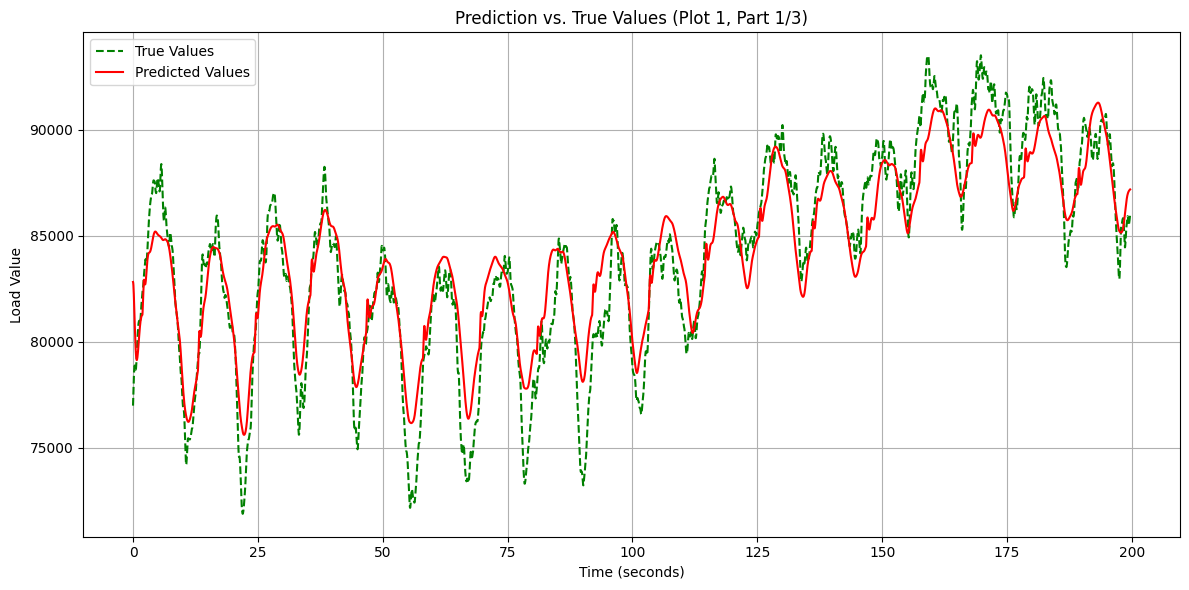

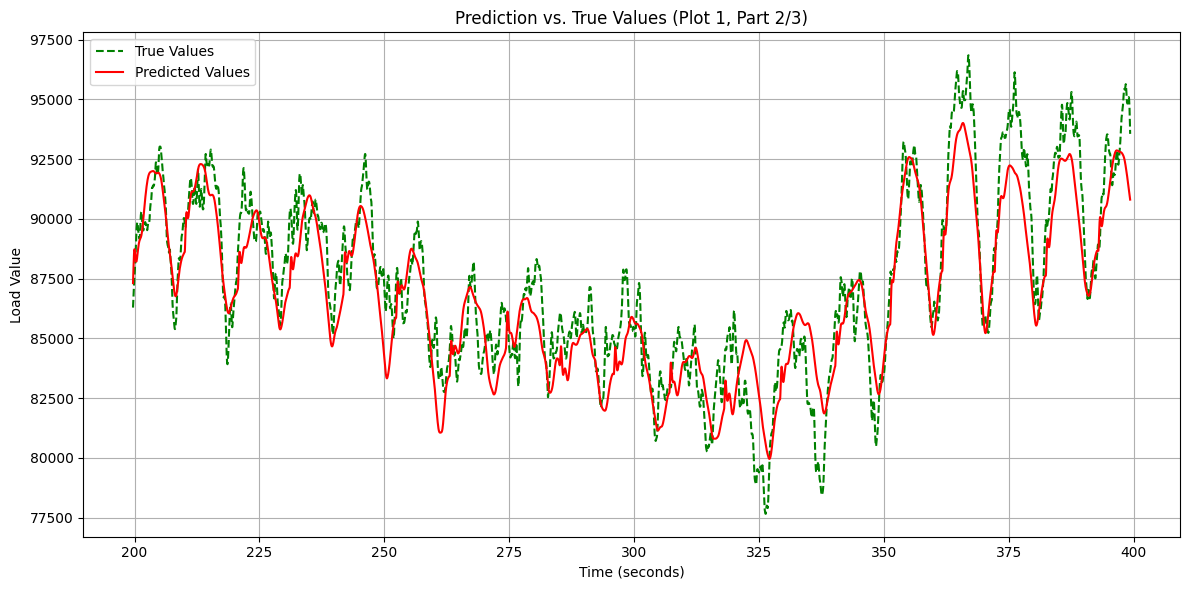

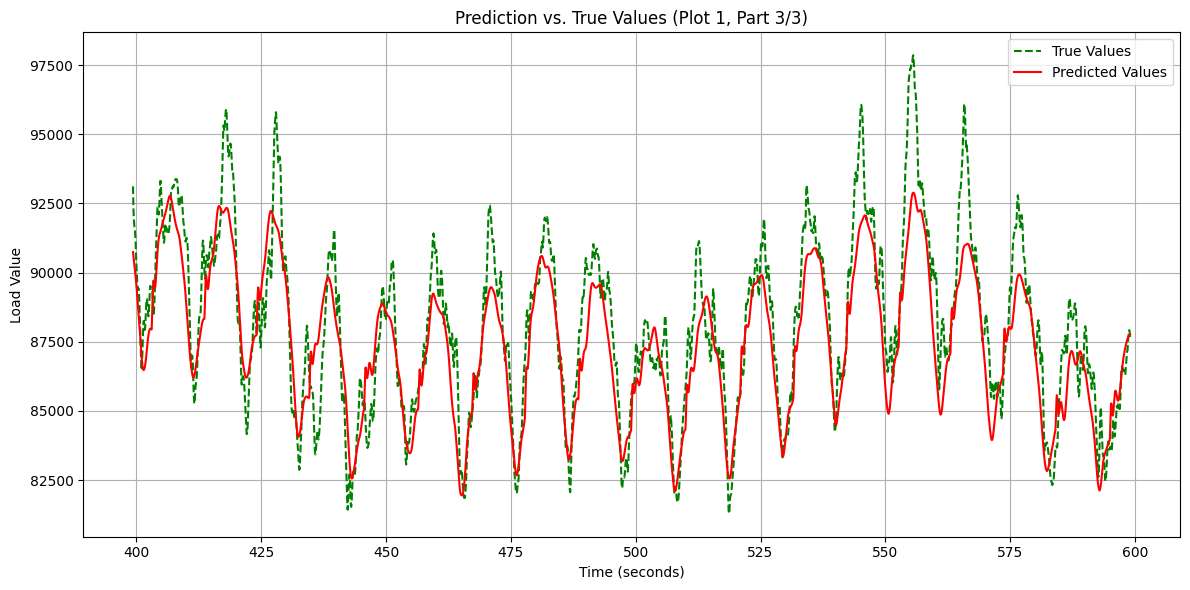

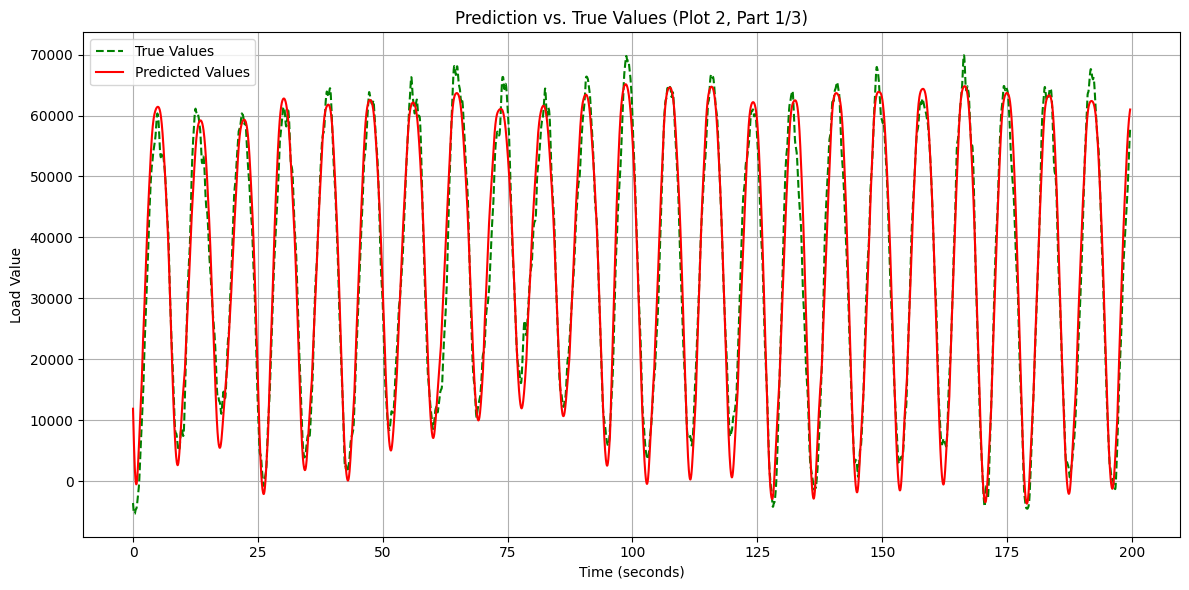

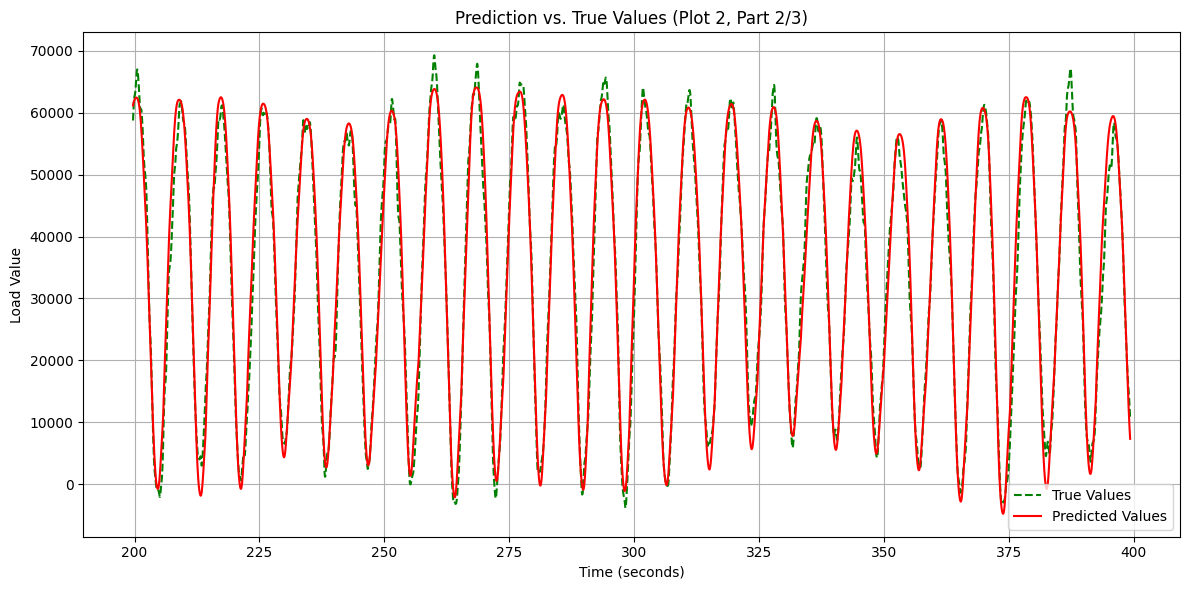

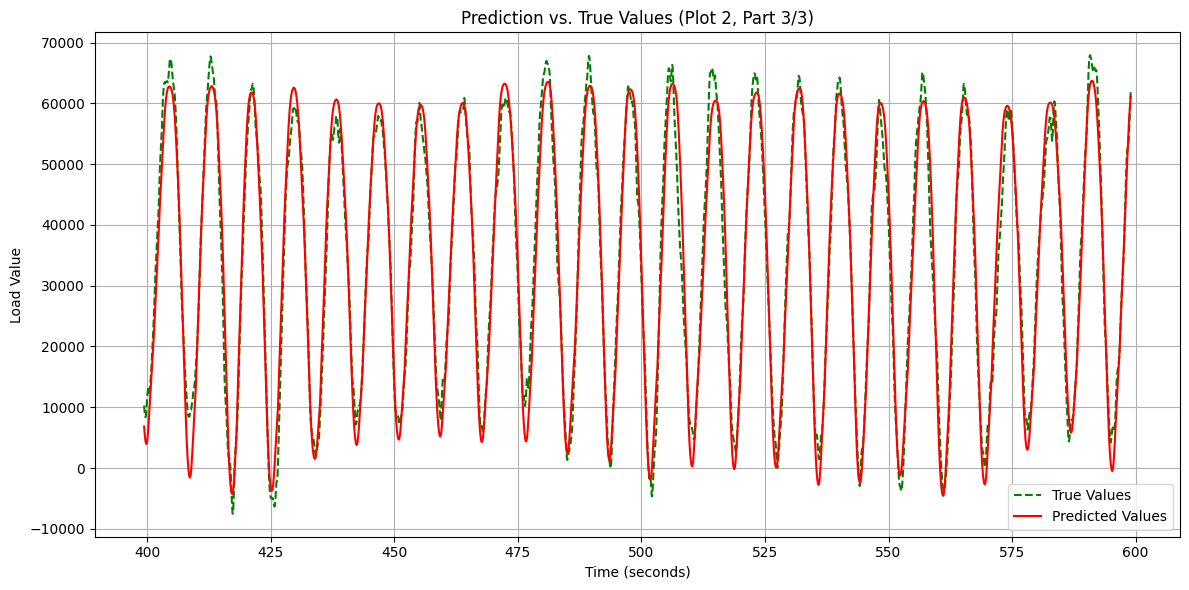

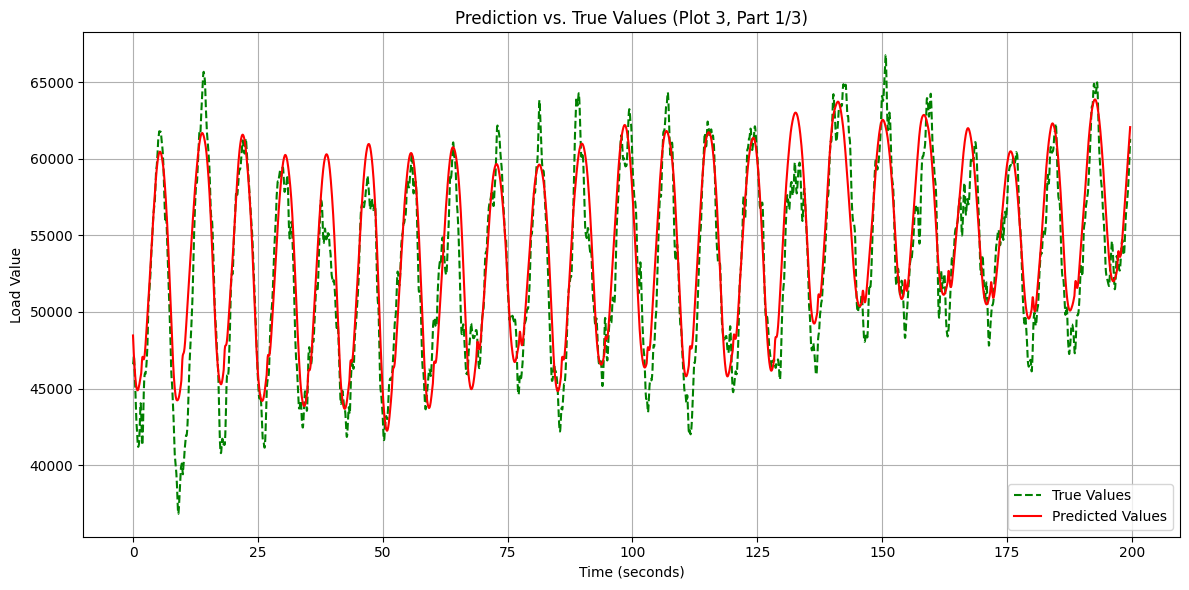

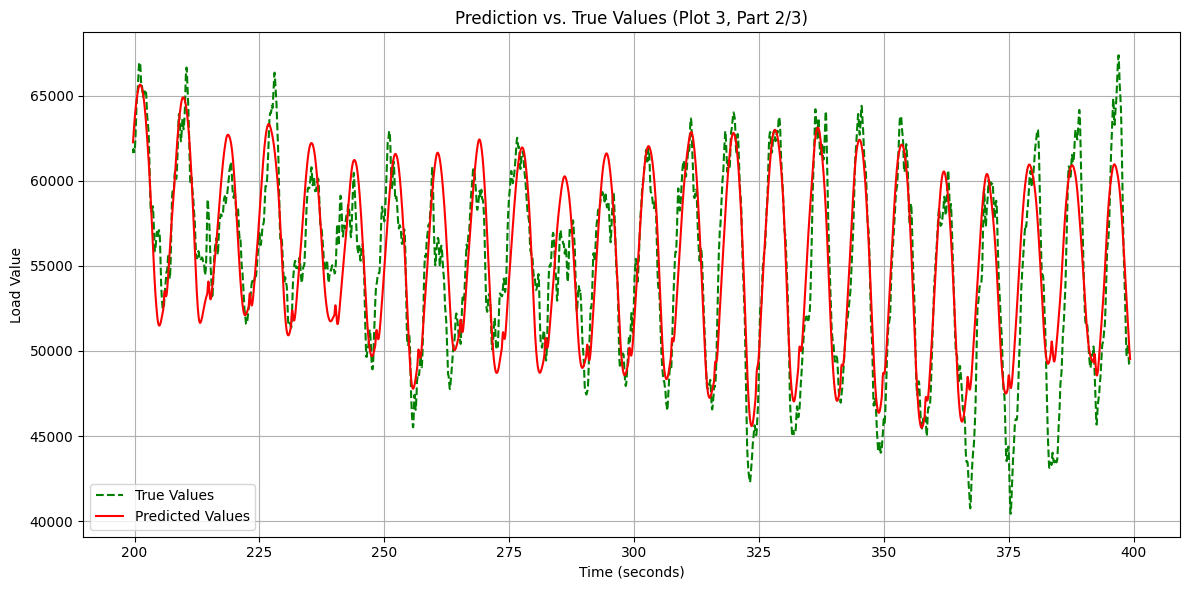

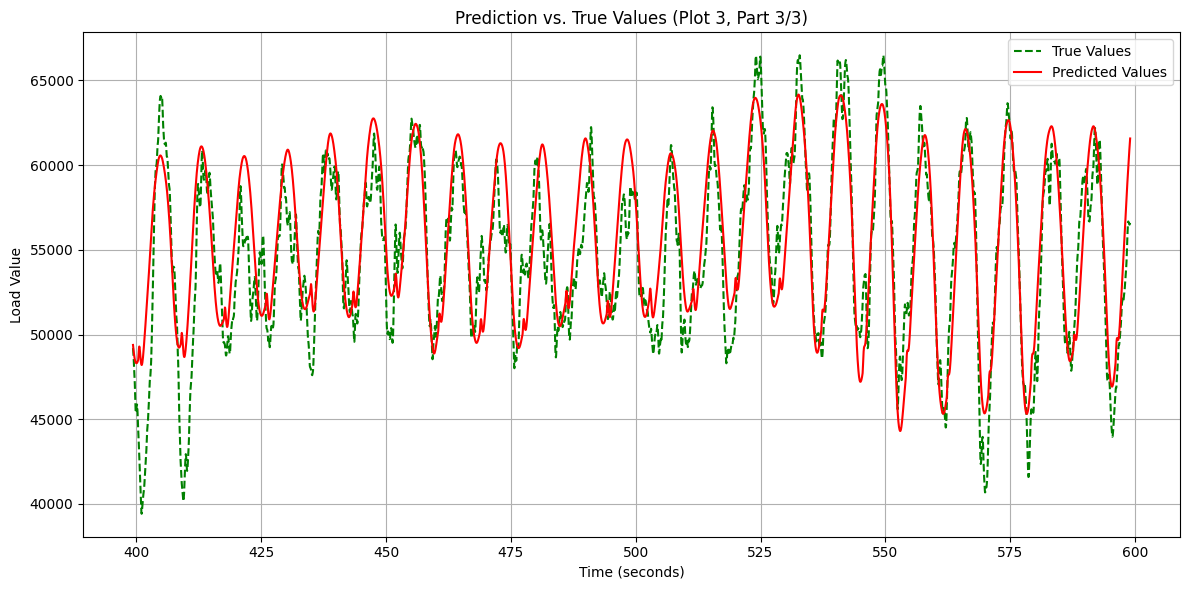

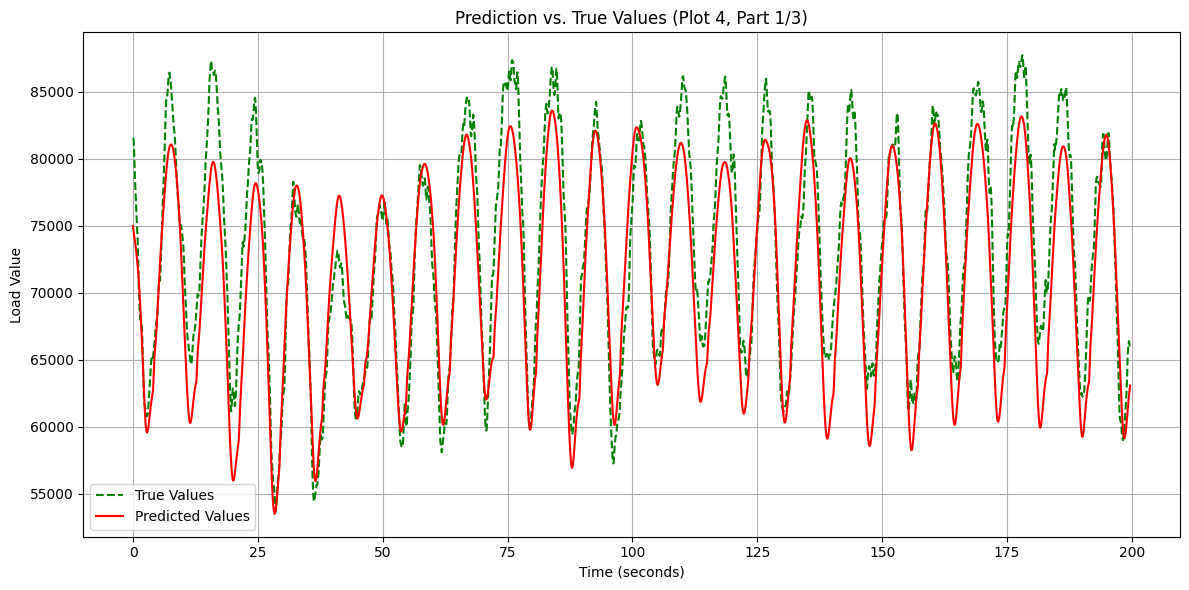

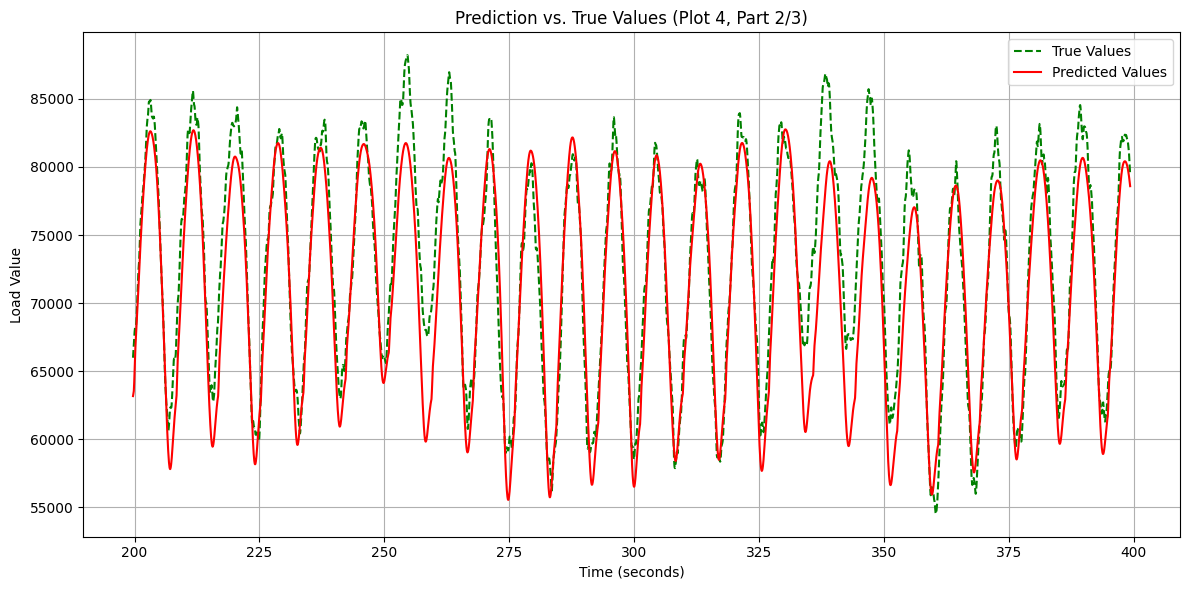

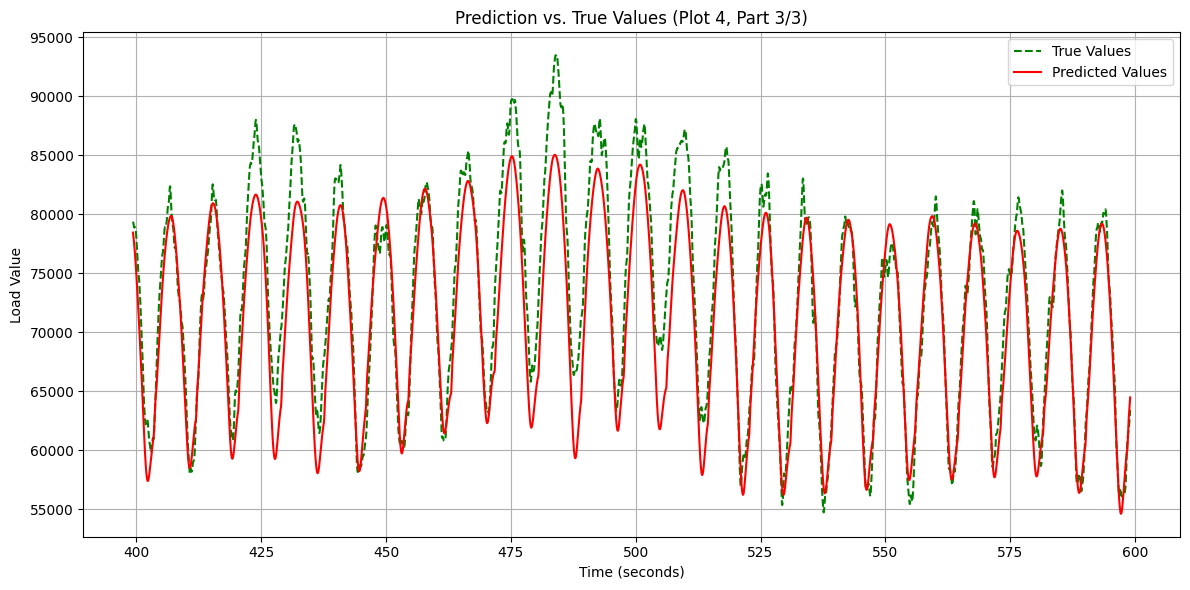

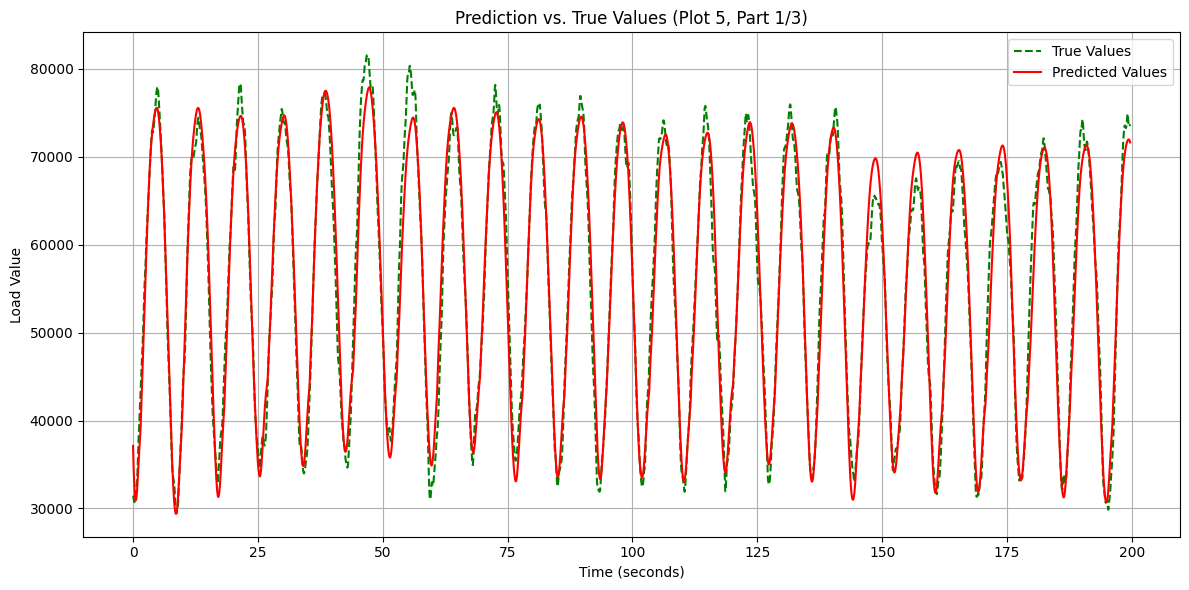

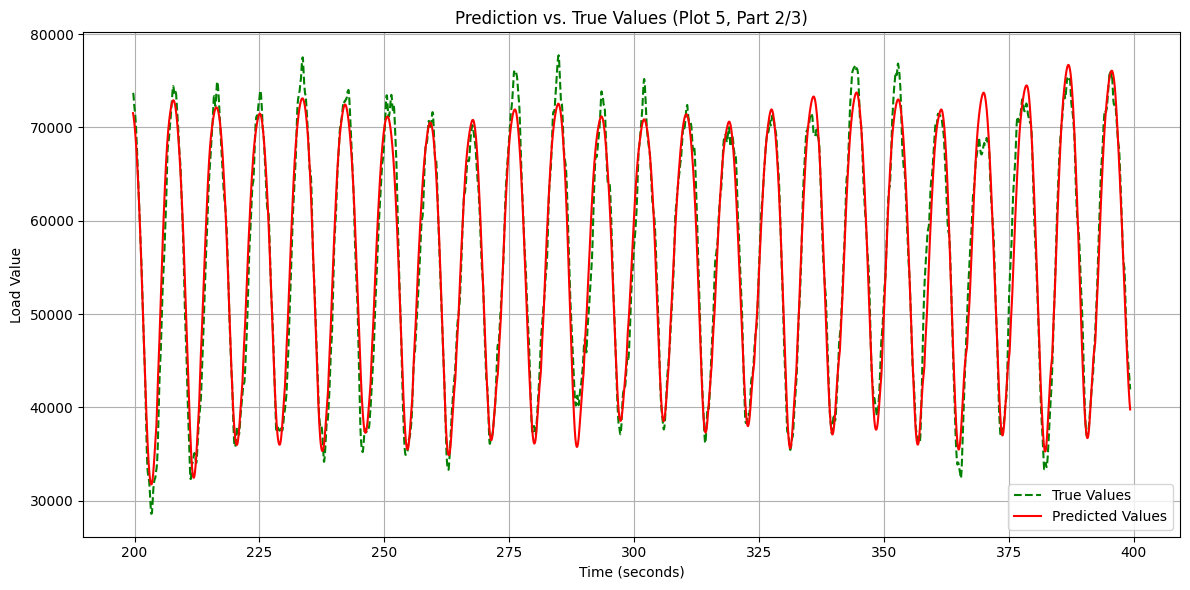

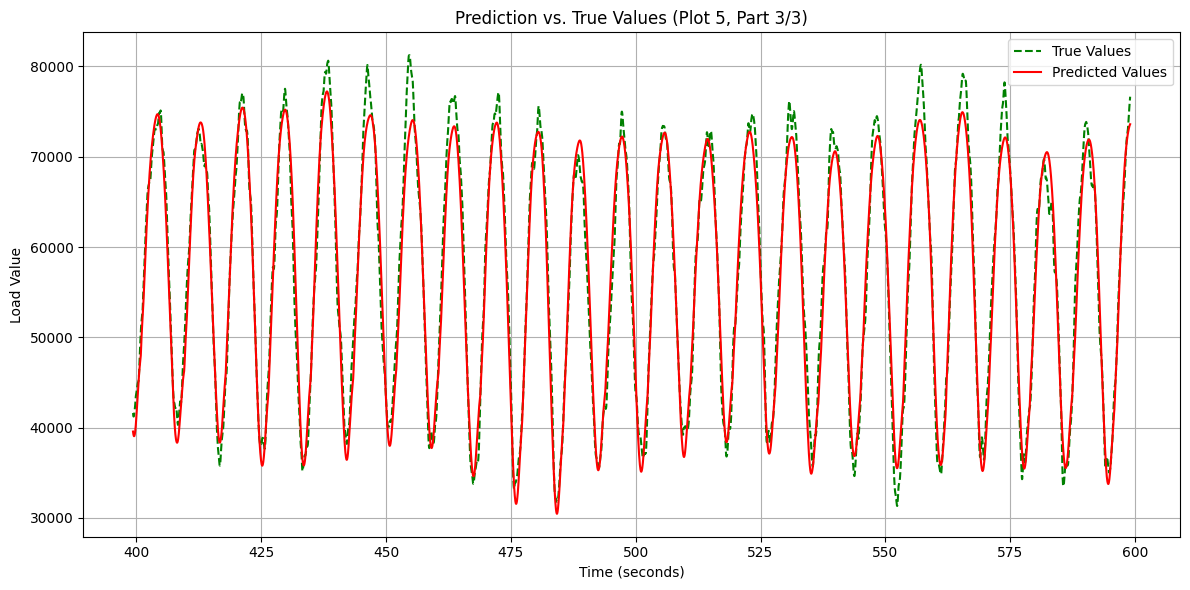

In [7]:
# Create model
input_height = 11            # Height of the 2D input field
input_width = 14            # Width of the 2D input field
hidden_dim = 128            # Hidden dimension of LSTM
output_dim = 1              # Output dimension (load value)
num_layers = 3              # Number of LSTM layers
dropout_prob = 0.2          # Dropout_prob of LSTM
kernel_size = 3             # Kernel size for CNN
out_channels = 1            # Output channels of CNN
stride = 1                  # Stride of CNN


model = WindTurbineLoadPredictor(hidden_dim=hidden_dim, 
                                 output_dim=output_dim, 
                                 num_layers=num_layers,
                                 kernel_size=kernel_size,
                                 out_channels=out_channels,
                                 stride=stride,
                                 input_height=input_height,
                                 input_width=input_width,
                                 dropout_prob=dropout_prob)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.load_state_dict(torch.load((model_path), weights_only=True))
# Define the loss function and optimizer
loss_fn = nn.MSELoss()

# Evaluate the model and plot inference
test_loss = evaluate(model, dataloaders['test'], loss_fn, device=device)
plot_predictions(model=model, dataloader=dataloaders['test'], num_parts=3, num_plots=5)